## Clustering

### KMeans

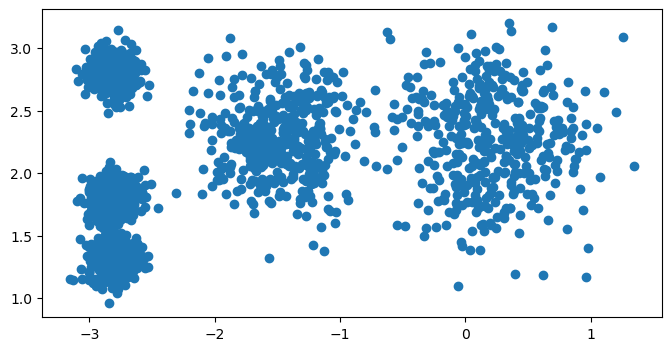

In [22]:
# make some data
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

plt.figure(figsize=(8,4))
plt.scatter(X[:, 0], X[:, 1])

In [23]:
from sklearn.cluster import KMeans

k=5
kmeans = KMeans(n_clusters=k)
y_pred=kmeans.fit_predict(X)
y_pred

array([1, 4, 3, ..., 2, 3, 4])

In [24]:
kmeans.cluster_centers_

array([[-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566],
       [-2.79290307,  2.79641063],
       [ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999]])

In [25]:
X_new = np.array([[0,2], [3,2], [-3,3], [-3,-2.5]])
kmeans.predict(X_new)

array([3, 3, 2, 1])

In [26]:
kmeans.transform(X_new) # distance between each instance to every centroid

array([[1.49439034, 2.88633901, 2.9042344 , 0.32995317, 2.81093633],
       [4.4759332 , 5.84236351, 5.84739223, 2.80290755, 5.80730058],
       [1.69136631, 1.71086031, 0.29040966, 3.29399768, 1.21475352],
       [5.02544607, 3.80606428, 5.30045797, 5.73681686, 4.30564816]])

In [27]:
kmeans.inertia_

211.59853725816836

### centroid initialization

In [28]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

In [29]:
kmeans.inertia_

211.59853725816836

In [30]:
kmeans.score(X) # negative inertia

-211.59853725816836

In [31]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

minibatch_kmeans.inertia_

C:\Users\hejin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


211.652398504332

### elbow method to find optimal k

In [36]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

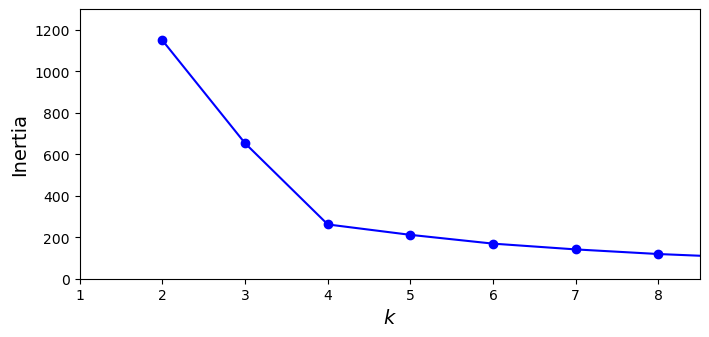

In [37]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
plt.show() # 4 is optimal

### measure performance (not using inertia which will definitely increase as k increase)

In [40]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

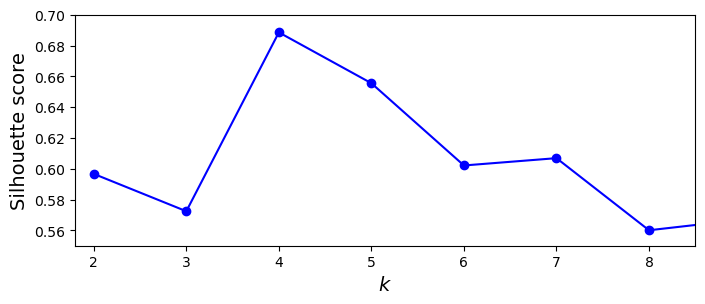

In [44]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show() # 4 is optimal

### color segmentation

In [51]:
import os
from matplotlib.image import imread
image = imread(os.path.join('images/unsupervised_learning/', 'ladybug.png'))
image.shape # height, width, number of color channels (RGB)

(533, 800, 3)

In [53]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

### preprocessing with clustering

In [55]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y = True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

In [58]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [59]:
pipeline.score(X_test, y_test)

0.9777777777777777

# use grid search to find the optimal number of clusters

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

C:\Users\hejin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)})

In [62]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [63]:
grid_clf.score(X_test, y_test)

0.9822222222222222

### semi-supervised learning

In [64]:
n_labeled = 50
# train logistic regression
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
# measure performance
log_reg.score(X_test, y_test)

0.8333333333333334

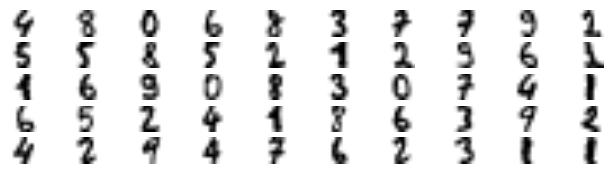

In [65]:
# find representative image, the closest to the centroid for each cluster
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]
# plot
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [67]:
# label each representative
y_representative_digits = np.array(y_train[representative_digit_idx])

In [68]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

In [70]:
# propagate (spread the label to all instances in the corresponding cluster)
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

In [76]:
# propagate to 20% of the instance
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1 # outside 20% close

partially_propagated = (X_cluster_dist != -1) # within 20% close
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.94

In [77]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

### DBSCAN (cannot predict on new instance)

In [78]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_[:10] # -1 means outlier

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [80]:
len(dbscan.core_sample_indices_)

808

In [81]:
dbscan.core_sample_indices_[:10] # index of core instance

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [82]:
dbscan.components_[:3] # core instance

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [83]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X) # perform better

DBSCAN(eps=0.2)

In [84]:
dbscan = dbscan2

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_]) # fit on core instance

KNeighborsClassifier(n_neighbors=50)

In [85]:
# perform predict
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

knn.predict_proba(X_new)

C:\Users\hejin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

In [86]:
# identify outlier
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

### Gaussian Mixture model

In [87]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [88]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [89]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [90]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

In [91]:
gm.converged_

True

In [92]:
gm.n_iter_

4

In [93]:
# hard clustering
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [94]:
# soft clustering
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

In [95]:
X_new, y_new = gm.sample(6)
X_new, y_new

(array([[-0.86944074, -0.32767626],
        [ 0.29836051,  0.28297011],
        [-2.8014927 , -0.09047309],
        [ 3.98203732,  1.49951491],
        [ 3.81677148,  0.53095244],
        [ 2.84104923, -0.73858639]]),
 array([0, 0, 1, 2, 2, 2]))

In [96]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

In [98]:
gm.bic(X), gm.aic(X)

(8189.747000497187, 8102.521720382149)

### Bayesian Gaussian Mixture model

In [99]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2) # only 3 clusters are needed

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])